# Setup system

In [1]:
# install library nesccesery
!pip install pyspark
!pip install findspark
!pip install shapely
!pip install apache-sedona

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import pyspark and check the version
import pyspark
print(pyspark.__version__)

3.5.1


In [3]:
# import finspark and check the path
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.5.1-bin-hadoop3'

In [4]:
# import library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, year, month, countDistinct, sum, dense_rank, when, mean
from pyspark.sql.functions import when, from_unixtime, unix_timestamp, abs, hour, expr, avg, corr, to_date, date_format
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter
from sedona.core.enums import GridType
from sedona.core.SpatialRDD import PointRDD
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.spatialOperator import KNNQuery
from sedona.core.enums import IndexType
from shapely.geometry import Point
from pyspark.ml.feature import Imputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

In [5]:
# create spark from SparkSession
spark = SparkSession.\
builder.\
appName('app').\
config("spark.serializer", KryoSerializer.getName). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
      'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.0,'
      'org.datasyslab:geotools-wrapper:1.4.0-28.2,'
      'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1'). \
getOrCreate()


In [6]:
# create the sql context and registrator Sedona
sqlContext = SparkSession(spark)
SedonaRegistrator.registerAll(spark)

C:\Users\precison 5520\AppData\Local\Temp\ipykernel_10096\1085458390.py:2: DeprecationWarning: Call to deprecated function registerAll (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  SedonaRegistrator.registerAll(spark)
C:\ProgramData\anaconda3\Lib\site-packages\sedona\register\geo_registrator.py:45: DeprecationWarning: Call to deprecated function register (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  cls.register(spark)


True

In [7]:
# create path to connect with mongodb
uri = "mongodb://localhost:27017"

In [8]:
# create path to connect with mongodb atlas
uri_Atlas="mongodb+srv://PhuongTran:Thanhphhuong110@@cummaytinh1.n2y9rwk.mongodb.net/?retryWrites=true&w=majority"

In [9]:
# read dataset from mogodb local
driver_df = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "driver_details") \
    .load()

truck_df = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "truck_details") \
    .load()

routes_df = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "route_details") \
    .load()


city_details = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "city_details") \
    .load()

truck_schedule_data = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "truck_schedule_data") \
    .load()


weather_data = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "weather_data") \
    .load()

traffic_data = spark.read.format("mongo") \
    .option("uri", uri) \
    .option("database", "ETA_Trucks") \
    .option("collection", "traffic_data") \
    .load()


# Chart samples

In [10]:
# create the chart sample
def historam(df, column):
    data = df.select(column).toPandas()
    sns.histplot(data[column], kde=False, bins=20)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column}")
    plt.show()

def boxplot(df, column):
    data = df.select(column).toPandas()
    sns.boxplot(data=data)
    plt.xlabel(column)
    plt.ylabel("Value")
    plt.title(f"Boxplot of {column}")
    plt.show()

def heatmap(df, column):
    data = df.select(*column).toPandas()
    corr = data.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

def scatter(df, x_col, y_col):
    data = df.select(x_col, y_col).toPandas()
    sns.scatterplot(data = data, x = x_col, y = y_col)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Scatter Plot between {x_col} and {y_col}")
    plt.show()

## Analyze driver characteristics wiht driver_df dataset:

In [11]:
# Check the characteristics of the data
driver_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- driving_style: string (nullable = true)
 |-- experience: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- name: string (nullable = true)
 |-- ratings: double (nullable = true)
 |-- vehicle_no: string (nullable = true)



In [12]:
# show top 5 rows in data
driver_df.show(5)

+--------------------+---+--------------------+-------------+----------+------+--------------+-------+--------------------+
|                 _id|age|           driver_id|driving_style|experience|gender|          name|ratings|          vehicle_no|
+--------------------+---+--------------------+-------------+----------+------+--------------+-------+--------------------+
|{65df3f5073bdaf54...| 52|c3173876aeac46048...| conservative|        13|  male| Scott Hawkins|    2.6|2f0705c938e545a0a...|
|{65df3f5073bdaf54...| 41|40287c65b040442f8...|    proactive|        22|  male|Tyler Saunders|    3.3|765d4022c30848c3a...|
|{65df3f5073bdaf54...| 54|52c6e171127e475eb...|    proactive|        14|  male|  John Parsons|    2.0|3e6c63a346d14608a...|
|{65df3f5073bdaf54...| 47|84aadb12672d4454b...| conservative|         6|  male|  James Miller|    4.3|5c80f31e59d84908a...|
|{65df3f5073bdaf54...| 48|eafe1b74784e49f0b...| conservative|        12|  male|Gregory Walton|    4.1|0c5537386a614cbaa...|
+-------

In [13]:
# statistics of the describe columns have integer format
driver_df.select(['age', 'experience', 'ratings']).describe().show()

+-------+-----------------+-----------------+------------------+
|summary|              age|       experience|           ratings|
+-------+-----------------+-----------------+------------------+
|  count|           200000|           200000|            200000|
|   mean|         47.49286|          10.4749|2.7057284999999904|
| stddev|5.003249362456383|5.609362469544626|1.1415121766928296|
|    min|               25|              -12|               1.0|
|    max|               71|               34|               5.0|
+-------+-----------------+-----------------+------------------+



In [14]:
#driver_null_missing = driver_df.isnull().sum()/driver_df.isnull().count().sort_values(descending = True).todataframes()
driver_df_missing = driver_df.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in driver_df.columns
])
driver_df_missing.show()

+-----------+-----------+-----------------+---------------------+------------------+------------------+------------+---------------+------------------+
|_id_miss(%)|age_miss(%)|driver_id_miss(%)|driving_style_miss(%)|experience_miss(%)|    gender_miss(%)|name_miss(%)|ratings_miss(%)|vehicle_no_miss(%)|
+-----------+-----------+-----------------+---------------------+------------------+------------------+------------+---------------+------------------+
|        0.0|        0.0|              0.0|   3.9699999999999958|               0.0|1.9445000000000046|         0.0|            0.0|               0.0|
+-----------+-----------+-----------------+---------------------+------------------+------------------+------------+---------------+------------------+



In [15]:
# Coppy driver_df to driver_df1
driver_df1 = driver_df

#replace the null value by mode
inputCol = ["driving_style", "gender"]

driver_mod = {}
for c in inputCol:
    mode = driver_df1.select(c).groupBy(c).count().orderBy(col("count").desc()).select(c).first()[0]
    driver_mod[c] = mode

for c, mode in driver_mod.items():
    driver_df1 = driver_df1.withColumn(c, when(col(c).isNull(), mode).otherwise(col(c)))

Average Age of Drivers: 47.49286


C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


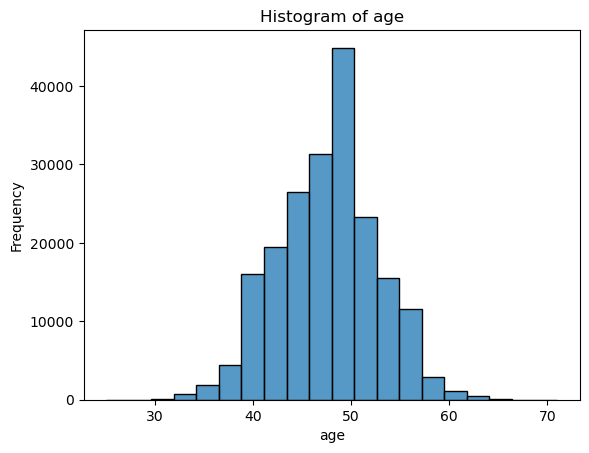

In [16]:
# Explore the distribution of age
# Calculate the average age
average_age = driver_df1.agg(avg("age")).collect()[0][0]
print(f"Average Age of Drivers: {average_age}")

historam(driver_df1, "age")

### The ages of the drivers participating in the study ranged from 25 to 71 years old, with an average age of 47 years old, with most drivers being from 40 to 55 years old.

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


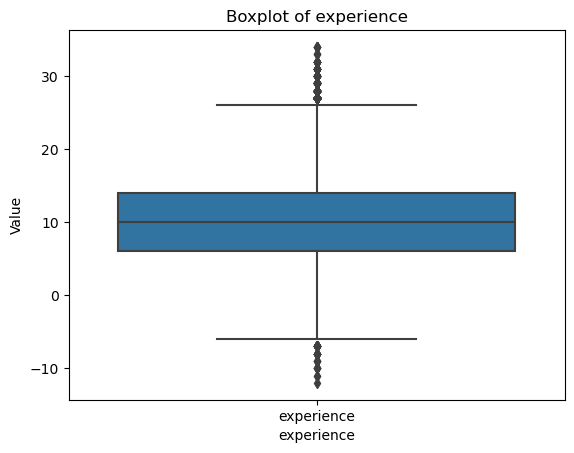

In [17]:
# Explore the distribution of experience of the driver
boxplot(driver_df1, "experience")

#### In the chart above, we see that there are a few drivers displaying experience as a negative number, this is impossible, it can be seen that there is some confusion in data input or some other unexpected error. We will remove it to avoid affecting the accuracy of the analysis

In [18]:
# remove the experience have nagetive data
driver_df1 = driver_df1.filter(col("experience") > 0)

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


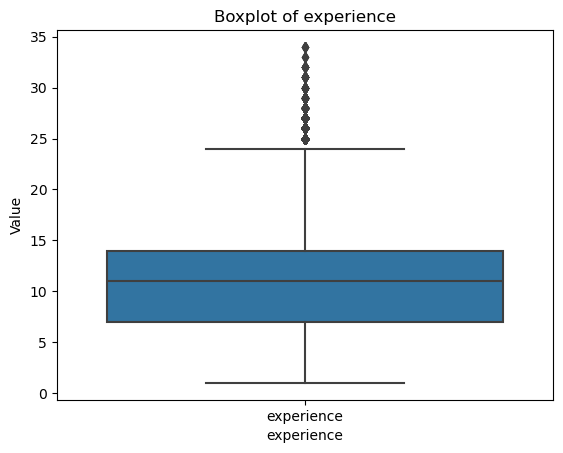

In [19]:
# visualization
boxplot(driver_df1, "experience")

#### After eliminating erroneous data, we see that there are some outlier data with years of experience of 25 years or more. For this oulier we should consider keeping them, because this is potentially a more important characteristic to evaluate the possibility of delay or not.

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


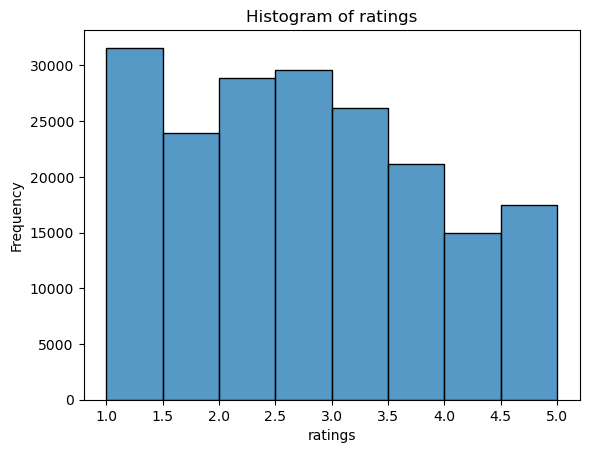

In [24]:
# Explore the distribution of driving style
data = driver_df1.select("ratings").toPandas()
sns.histplot(data["ratings"], kde=False, bins=8)
plt.xlabel("ratings")
plt.ylabel("Frequency")
plt.title(f"Histogram of ratings")
plt.show()

#### Ratings range from 1 to 5 stars. Relatively distributed from 2 to 5 stars. However, there is one notable point: the highest 1-1.5 star rating and it is also very flattering that this is a review score from customers, maybe it is due to driving style, or late deliveries.

+-------------+------+
|driving_style| count|
+-------------+------+
| conservative| 88900|
|    proactive|104790|
+-------------+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

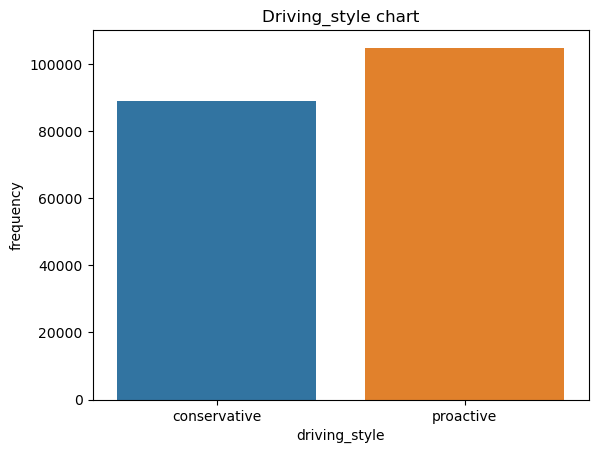

In [129]:
# Explore the distribution of driving style
driving_style = driver_df1.select("driving_style").groupBy("driving_style").count()
driving_style.show()

# visualization
data_driving = driving_style.toPandas()
sns.barplot(x = data_driving["driving_style"], y = data_driving["count"])
plt.xlabel("driving_style")
plt.ylabel("frequency")
plt.title("Driving_style chart")
plt.show()

#### There is a difference between driving styles, but not significant

+------+------+
|gender| count|
+------+------+
|female| 11491|
|  male|182199|
+------+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

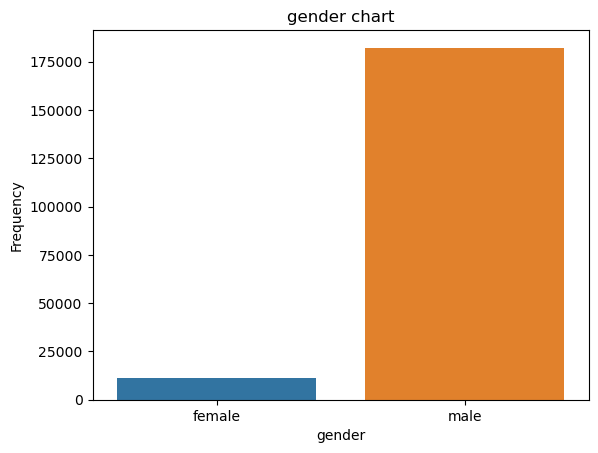

In [131]:
# Explore the distribution of gender of the driver
gender = driver_df1.select("gender").groupBy("gender").count()
gender.show()

# visualization
data_gender = gender.toPandas()
sns.barplot(x=data_gender["gender"], y=data_gender["count"])
plt.xlabel("gender")
plt.ylabel("Frequency")
plt.title("gender chart")
plt.show()

#### The drivers participating in the survey were mainly male, which is quite obvious due to the nature of the profession

In [25]:
# Define the filter conditions
filter_conditions = (
    (col("gender") == "male") &
    (col("experience") > 10) &
    (col("driving_style") == "proactive") &
    (
        ((col("age") >= 40) & (col("age") <= 55)) |
        (col("ratings") > 4)
    )
)

# Count the number of documents matching the filter conditions
count_driver = driver_df.filter(filter_conditions).count()
print(count_driver)

# Sort and limit the DataFrame to get the top 5 results
sorted_df = driver_df.filter(filter_conditions).sort(col("ratings").desc(), col("age")).limit(5)

sorted_df.show()

42299
+--------------------+---+--------------------+-------------+----------+------+-----------------+-------+--------------------+
|                 _id|age|           driver_id|driving_style|experience|gender|             name|ratings|          vehicle_no|
+--------------------+---+--------------------+-------------+----------+------+-----------------+-------+--------------------+
|{65df3f5e73bdaf54...| 39|76a283a440aa4799a...|    proactive|        11|  male|Michael Mcconnell|    5.0|a7022bf811ed40ef9...|
|{65df3f5a73bdaf54...| 40|843f66e8bcf2479e9...|    proactive|        11|  male|    Scott Johnson|    5.0|1efbcb288cb843c4b...|
|{65df3f5c73bdaf54...| 40|046ad46921104e6db...|    proactive|        11|  male|    Andrew Forbes|    5.0|254869b1ffac41fea...|
|{65df3f5273bdaf54...| 41|1a4b914157a949d6b...|    proactive|        19|  male|        Chad Ward|    5.0|d396e24ad6474d0d8...|
|{65df3f5373bdaf54...| 41|22faf877ea1c4c0aa...|    proactive|        16|  male|  Andrew Gallegos|    5.0|

In [26]:
# Calculate the average age grouped by gender and driving_style
result = driver_df1.groupBy("gender", "driving_style").agg(avg("age").alias("average_age"))

# Show the result
result.show()

+------+-------------+------------------+
|gender|driving_style|       average_age|
+------+-------------+------------------+
|female|    proactive|47.617490739249476|
|  male| conservative|   47.607249635246|
|  male|    proactive| 47.58790233412118|
|female| conservative| 47.44774706550549|
+------+-------------+------------------+



### We look at driving performance: consider whether drivers' ratings are affected by driving style (conservative or proactive).

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


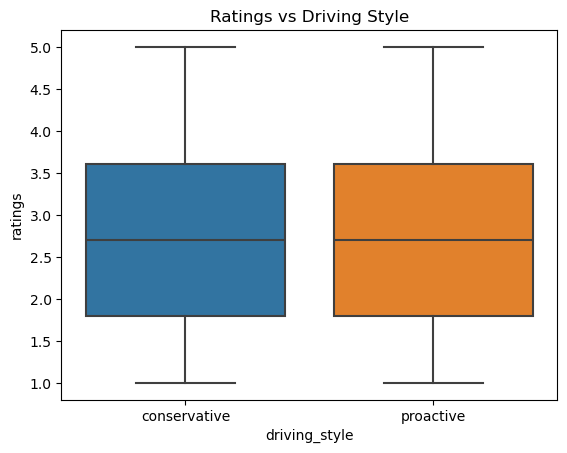

In [40]:
# visualization the driving_style and ratings columns
sns.boxplot(x="driving_style", y="ratings", data = compare_rating_style )
plt.title("Ratings vs Driving Style")
plt.show()

#### There is a significant correlation between the two columns with a correlation coefficient of 0.5, however according to the boxplot it appears that all driving styles have ratings from 1 star to 5 stars. This shows that the correlation from the above coefficient is a coincidence.

## Evaluate truck performance with truck_df dataset

In [30]:
# Check the characteristics of the data
truck_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- load_capacity_pounds: double (nullable = true)
 |-- mileage_mpg: integer (nullable = true)
 |-- truck_age: integer (nullable = true)
 |-- truck_id: string (nullable = true)



In [31]:
# show top 5 the information
truck_df.show(5)

+--------------------+---------+--------------------+-----------+---------+--------------------+
|                 _id|fuel_type|load_capacity_pounds|mileage_mpg|truck_age|            truck_id|
+--------------------+---------+--------------------+-----------+---------+--------------------+
|{65df419b73bdaf54...|   diesel|             20000.0|         24|       12|2f0705c938e545a0a...|
|{65df419b73bdaf54...|      gas|              6000.0|         18|       17|765d4022c30848c3a...|
|{65df419b73bdaf54...|      gas|             15000.0|         17|       17|3e6c63a346d14608a...|
|{65df419b73bdaf54...|   diesel|             15000.0|         23|       18|5c80f31e59d84908a...|
|{65df419b73bdaf54...|   diesel|              4000.0|         21|        6|0c5537386a614cbaa...|
+--------------------+---------+--------------------+-----------+---------+--------------------+
only showing top 5 rows



In [32]:
# show the describe of columns have integer format
truck_df.select(['load_capacity_pounds', 'mileage_mpg', 'truck_age']).describe().show()

+-------+--------------------+------------------+-----------------+
|summary|load_capacity_pounds|       mileage_mpg|        truck_age|
+-------+--------------------+------------------+-----------------+
|  count|              192123|            200000|           200000|
|   mean|   9007.703398343769|          20.80687|         14.49133|
| stddev|   5631.728014764157|3.5572312368709382|4.993816128182662|
|    min|              3000.0|                 8|               -6|
|    max|             20000.0|                32|               36|
+-------+--------------------+------------------+-----------------+



#### According to the Truck_age column, the age of the truck has negative numeric data, which also creates doubts about the data, we remove those negative values.

In [33]:
# Coppy truck_df into truck_df1
truck_df1 = truck_df

truck_df1 = truck_df1.filter(col("truck_age") >= 0)

In [34]:
# show the describe of columns have integer format
truck_df1.select(['load_capacity_pounds', 'mileage_mpg', 'truck_age']).describe().show()

+-------+--------------------+------------------+------------------+
|summary|load_capacity_pounds|       mileage_mpg|         truck_age|
+-------+--------------------+------------------+------------------+
|  count|              191993|            199866|            199866|
|   mean|   9007.484647877787|20.806840583190738|14.502271521919686|
| stddev|   5631.602589841603| 3.557290556187595| 4.977496437610574|
|    min|              3000.0|                 8|                 0|
|    max|             20000.0|                32|                36|
+-------+--------------------+------------------+------------------+



In [35]:
# Checking any missing
truck_df_missing = truck_df.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in truck_df.columns
])
truck_df_missing.show()

+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+
|_id_miss(%)|fuel_type_miss(%)|load_capacity_pounds_miss(%)|mileage_mpg_miss(%)|truck_age_miss(%)|truck_id_miss(%)|
+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+
|        0.0|3.956000000000004|          3.9385000000000003|                0.0|              0.0|             0.0|
+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+



####  There are some missing values in the fuel_type and load_capacity_pounds columns, we replace the missing values by mode

In [36]:
#replace the null value by mode
inputCol = ["fuel_type", "load_capacity_pounds"]

truck_mod = {}
for c in inputCol:
    mode = truck_df1.select(c).groupBy(c).count().orderBy(col("count").desc()).select(c).first()[0]
    truck_mod[c] = mode

for c, mode in truck_mod.items():
    truck_df1 = truck_df1.withColumn(c, when(col(c).isNull(), mode).otherwise(col(c)))

In [37]:
# Checking any missing
truck_df_missing1 = truck_df1.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in truck_df1.columns
])
truck_df_missing1.show()

+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+
|_id_miss(%)|fuel_type_miss(%)|load_capacity_pounds_miss(%)|mileage_mpg_miss(%)|truck_age_miss(%)|truck_id_miss(%)|
+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+
|        0.0|              0.0|                         0.0|                0.0|              0.0|             0.0|
+-----------+-----------------+----------------------------+-------------------+-----------------+----------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


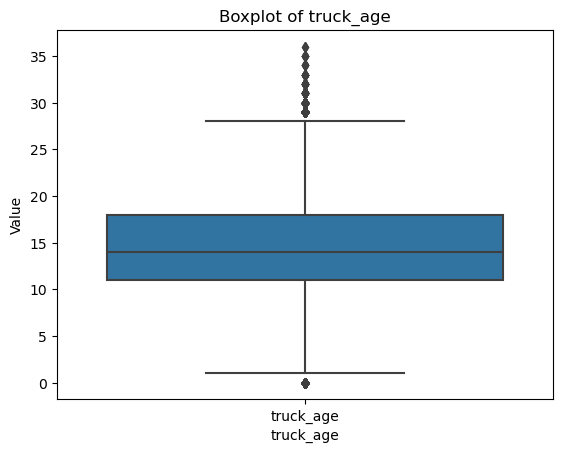

In [38]:
# Analysis of age distribution of trucks
boxplot(truck_df1, "truck_age")

#### Most trucks have been used for quite a long time, the average age of trucks is about 14.5 years. whether this is likely to affect the vehicle's performance or not

+--------------------+-----+
|load_capacity_pounds|count|
+--------------------+-----+
|             10000.0|29961|
|              3000.0|39927|
|             20000.0|16126|
|              6000.0|30143|
|              4000.0|30085|
|             15000.0|53624|
+--------------------+-----+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

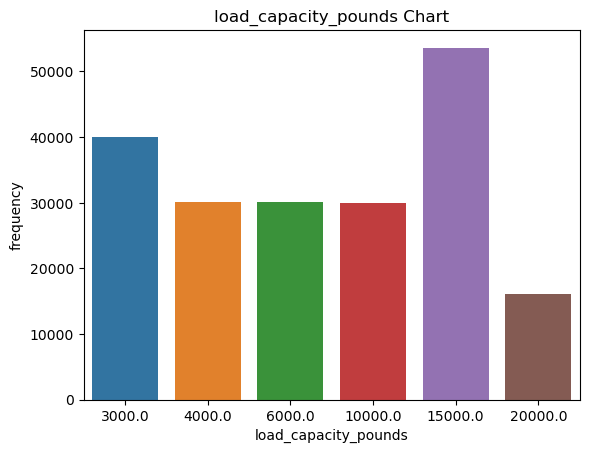

In [39]:
# Analysis distribution of load capacity in years.
load_capacity_pounds = truck_df1.select("load_capacity_pounds").groupBy("load_capacity_pounds").count()
load_capacity_pounds.show()

# visualization
load_capacity_pounds_data = load_capacity_pounds.toPandas()
sns.barplot(x= load_capacity_pounds_data["load_capacity_pounds"], y= load_capacity_pounds_data["count"])
plt.xlabel("load_capacity_pounds")
plt.ylabel("frequency")
plt.title("load_capacity_pounds Chart")
plt.show()

#### loading capacity of the truck in years most of 15000

+---------+------+
|fuel_type| count|
+---------+------+
|      gas| 84244|
|   diesel|115622|
+---------+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

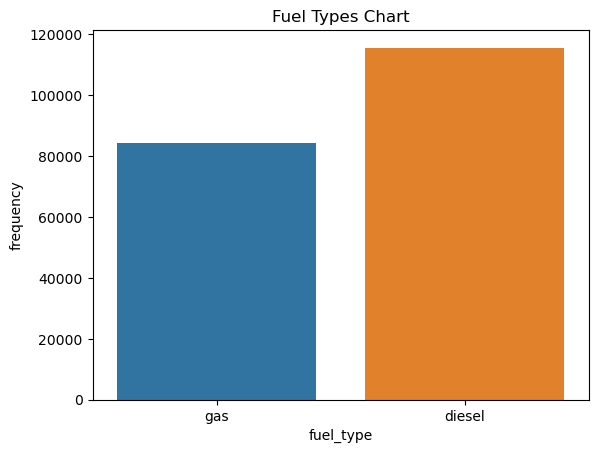

In [40]:
# Analysis distribution of fuel_types
fuel_types = truck_df1.select("fuel_type").groupBy("fuel_type").count()
fuel_types.show()

# visualization
fuel_data = fuel_types.toPandas()
sns.barplot(x= fuel_data["fuel_type"], y= fuel_data["count"])
plt.xlabel("fuel_type")
plt.ylabel("frequency")
plt.title("Fuel Types Chart")
plt.show()

#### The ratio of using diesel is higher than gas, because it is likely that most diesel engines will bring more fuel economy and the load can also be larger.

+--------------------+------------------+
|load_capacity_pounds|    avg(truck_age)|
+--------------------+------------------+
|             10000.0| 14.51146490437569|
|              3000.0|14.537556039772586|
|             20000.0|14.494791020711894|
|              6000.0|14.524168131904588|
|              4000.0|14.467143094565397|
|             15000.0|14.480512457108757|
+--------------------+------------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

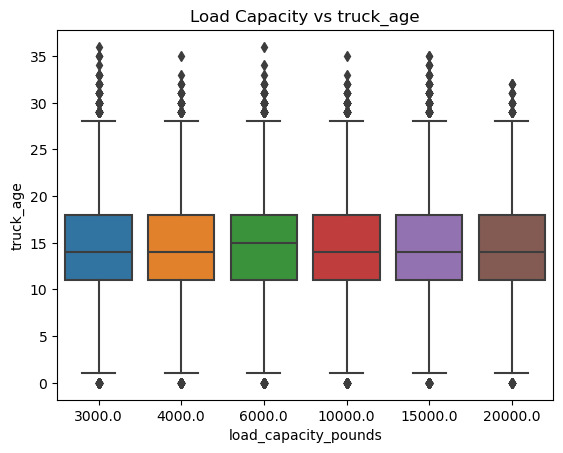

In [41]:
# Calculate the average age of trucks and learn the relationship between age and truck performance.
distribution = truck_df1.groupBy("load_capacity_pounds").agg({"truck_age": "mean"})
distribution.show()

# Visualization
sns.boxplot(x="load_capacity_pounds", y="truck_age", data=truck_df1.toPandas())
plt.title("Load Capacity vs truck_age")
plt.show()


#### with load performance varying across different years of trucks. shows that even though the number of years of use increases, maximum performance is still maintained

### Compare fuel consumption

+---------+------------------+
|fuel_type|  avg(mileage_mpg)|
+---------+------------------+
|      gas|17.498207587483975|
|   diesel| 23.21756240161907|
+---------+------------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

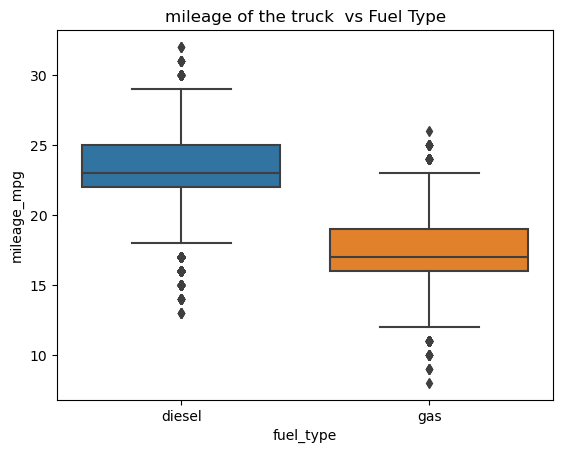

In [42]:
# Compare the average fuel consumption of different types of trucks and analyze the relationship between fuel type and fuel consumption.
distribution = truck_df1.groupBy("fuel_type").agg({"mileage_mpg": "mean"})
distribution.show()

# statistics of the 'fuel_type' and mileage_mpg columns
sns.boxplot(x="fuel_type", y="mileage_mpg", data=truck_df1.toPandas())
plt.title("mileage of the truck  vs Fuel Type")
plt.show()

#### The above data shows that diesel will save more fuel than gas. bring more economic efficiency

+---------+------------------+
|fuel_type|    avg(truck_age)|
+---------+------------------+
|      gas| 14.50108019562224|
|   diesel|14.503139540917818|
+---------+------------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

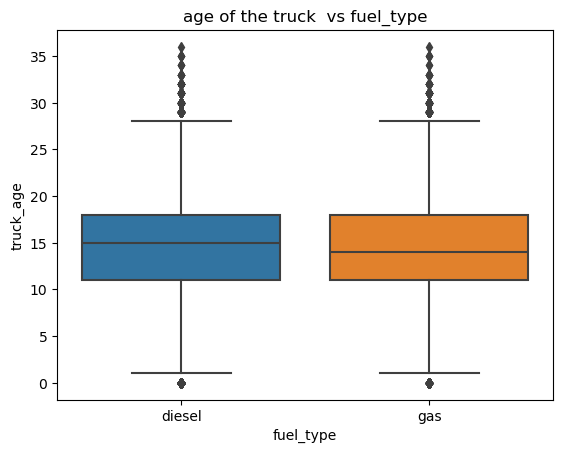

In [43]:
# statistics of the 'fuel_type' and truck_age columns
truck_df1.groupBy("fuel_type").agg({"truck_age": "mean"}).show()

sns.boxplot(x="fuel_type", y="truck_age", data=truck_df1.toPandas())
plt.title("age of the truck  vs fuel_type")
plt.show()

#### There is no big difference between trucks using different fuels, overall durability is similar

# routes_df 

In [45]:
# see the data type in dataset
routes_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- average_hours: double (nullable = true)
 |-- destination: string (nullable = true)
 |-- destination_lat: double (nullable = true)
 |-- destination_lon: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- origin: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_lon: double (nullable = true)
 |-- route_id: string (nullable = true)



In [46]:
# show the top 5 in dataset
routes_df.show(5)

+--------------------+-------------+----------------+---------------+---------------+--------+-------+----------+----------+--------------------+
|                 _id|average_hours|     destination|destination_lat|destination_lon|distance| origin|origin_lat|origin_lon|            route_id|
+--------------------+-------------+----------------+---------------+---------------+--------+-------+----------+----------+--------------------+
|{65df3f8073bdaf54...|        40.91|          Alaska|         16.559|        -93.973| 2045.33|Alabama|    42.998|   -78.185| Alabama_Alaska_5878|
|{65df3f8073bdaf54...|        39.22|         Arizona|         15.633|        -87.317| 1960.92|Alabama|    42.998|   -78.185|Alabama_Arizona_3285|
|{65df3f8073bdaf54...|        21.55|   Arkansas City|         37.062|        -97.038| 1077.52|Alabama|    42.998|   -78.185|Alabama_Arkansas_...|
|{65df3f8073bdaf54...|        43.73| California City|         35.126|       -117.985| 2186.33|Alabama|    42.998|   -78.185|

In [47]:
# show the describe of columns have a integer format
routes_df.select(['average_hours', 'destination_lat', 'destination_lon', 'distance', 'origin_lat', 'origin_lon']).describe().show()

+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|summary|    average_hours|  destination_lat|   destination_lon|          distance|        origin_lat|        origin_lon|
+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|  count|             2352|             2352|              2352|              2352|              2352|              2352|
|   mean| 52.9769812925169|33.50981632653087|-69.84981632652988|2648.8444727891215| 33.50981632653121|-69.84981632652969|
| stddev|58.47092904597492|17.78292905317311|52.876424843191096|2923.5500381344928|17.782929053173117|52.876424843191124|
|    min|             0.08|          -30.733|          -122.606|               3.9|           -30.733|          -122.606|
|    max|           209.42|           45.418|             150.6|          10471.22|            45.418|             150.6|
+-------+---------------

In [50]:
# Checking any missing
routes_df_missing = routes_df.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in routes_df.columns
])
routes_df_missing.show()

+-----------+---------------------+-------------------+-----------------------+-----------------------+----------------+--------------+------------------+------------------+----------------+
|_id_miss(%)|average_hours_miss(%)|destination_miss(%)|destination_lat_miss(%)|destination_lon_miss(%)|distance_miss(%)|origin_miss(%)|origin_lat_miss(%)|origin_lon_miss(%)|route_id_miss(%)|
+-----------+---------------------+-------------------+-----------------------+-----------------------+----------------+--------------+------------------+------------------+----------------+
|        0.0|                  0.0|                0.0|                    0.0|                    0.0|             0.0|           0.0|               0.0|               0.0|             0.0|
+-----------+---------------------+-------------------+-----------------------+-----------------------+----------------+--------------+------------------+------------------+----------------+



In [26]:
# no missing data in routes_df dataset
# Coppy driver_df to driver_df1
routes_df1 = routes_df

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


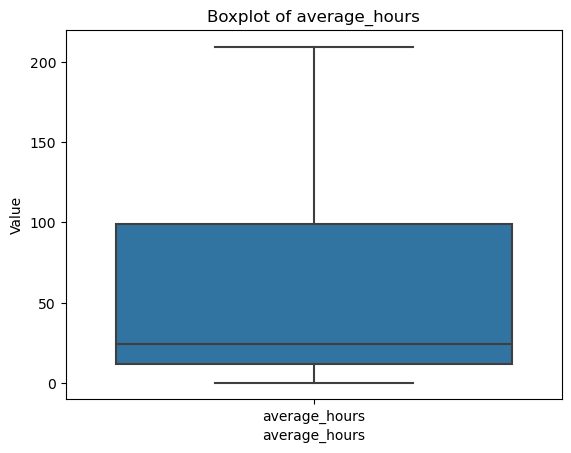

In [28]:
# statistics of the average hours
boxplot(routes_df1,"average_hours")

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


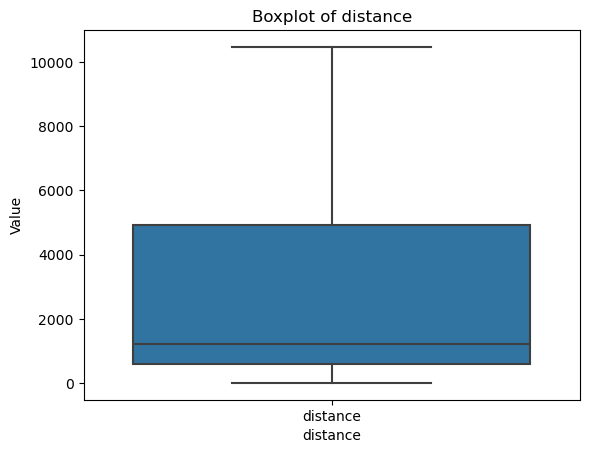

In [53]:
# statistics of the distance by boxplot
boxplot(routes_df1,"distance")

# city_details 

In [54]:
# show the information of data type
city_details.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- name: string (nullable = true)



In [55]:
# show the top 5 information in dataset
city_details.show(5)

+--------------------+-------+------+--------+---------------+
|                 _id|city_id|   lat|     lon|           name|
+--------------------+-------+------+--------+---------------+
|{65df3f2773bdaf54...|      1|42.998| -78.185|        Alabama|
|{65df3f2773bdaf54...|      2|16.559| -93.973|         Alaska|
|{65df3f2773bdaf54...|      3|15.633| -87.317|        Arizona|
|{65df3f2773bdaf54...|      4|37.062| -97.038|  Arkansas City|
|{65df3f2773bdaf54...|      5|35.126|-117.985|California City|
+--------------------+-------+------+--------+---------------+
only showing top 5 rows



In [57]:
# Checking any missing
city_details_missing = city_details.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in city_details.columns
])
city_details_missing.show()

+-----------+---------------+-----------+-----------+------------+
|_id_miss(%)|city_id_miss(%)|lat_miss(%)|lon_miss(%)|name_miss(%)|
+-----------+---------------+-----------+-----------+------------+
|        0.0|            0.0|        0.0|        0.0|         0.0|
+-----------+---------------+-----------+-----------+------------+



In [58]:
# no missing data in city_details dataset
# Coppy city_details to city_details1
city_details1 = city_details

# truck_schedule_data 

In [59]:
# show the information of data type
truck_schedule_data.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: string (nullable = true)
 |-- delay: integer (nullable = true)
 |-- destination: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- planned_eta: string (nullable = true)
 |-- route_id: string (nullable = true)
 |-- truck_id: string (nullable = true)



In [60]:
# show the top 5 in dataset
truck_schedule_data.show(5)

+--------------------+--------------------+-----+-------------+-------+--------------------+--------------------+--------------------+
|                 _id|                date|delay|  destination| origin|         planned_eta|            route_id|            truck_id|
+--------------------+--------------------+-----+-------------+-------+--------------------+--------------------+--------------------+
|{65df415773bdaf54...|2017-01-01 07:00:...|    0|Arkansas City|Alabama|2017-01-02 04:33:...|Alabama_Arkansas_...|7589affd1aa241549...|
|{65df415773bdaf54...|2017-01-01 07:00:...|    0|     Stamford|Alabama|2017-01-01 12:28:...|Alabama_Stamford_...|67fe5199640441ff9...|
|{65df415773bdaf54...|2017-01-01 07:00:...|    0|     Delaware|Alabama|2017-01-01 13:16:...|Alabama_Delaware_785|b354409d1bdb44a69...|
|{65df415773bdaf54...|2017-01-01 07:00:...|    0|Illinois City|Alabama|2017-01-01 20:13:...|Alabama_Illinois_...|66eeaa53d37c4bb89...|
|{65df415773bdaf54...|2017-01-01 07:00:...|    0| India

In [63]:
#driver_null_missing = driver_df.isnull().sum()/driver_df.isnull().count().sort_values(descending = True).todataframes()
truck_schedule_data_missing = truck_schedule_data.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in truck_schedule_data.columns
])
truck_schedule_data_missing.show()

+-----------+------------+-------------+-------------------+--------------+-------------------+----------------+----------------+
|_id_miss(%)|date_miss(%)|delay_miss(%)|destination_miss(%)|origin_miss(%)|planned_eta_miss(%)|route_id_miss(%)|truck_id_miss(%)|
+-----------+------------+-------------+-------------------+--------------+-------------------+----------------+----------------+
|        0.0|         0.0|          0.0|                0.0|           0.0|                0.0|             0.0|             0.0|
+-----------+------------+-------------+-------------------+--------------+-------------------+----------------+----------------+



In [64]:
# No missing data in truck_schedule_data dataset
# Coppy driver_df to driver_df1
truck_schedule_data1 = truck_schedule_data

+-----+------+
|delay| count|
+-----+------+
|    1| 37113|
|    0|528997|
+-----+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


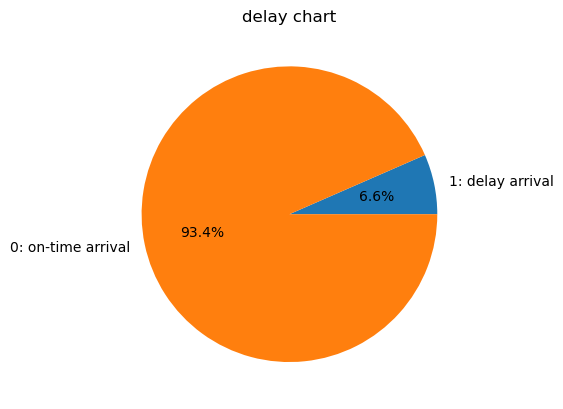

In [135]:
# explore the delay column in dataset
delay = truck_schedule_data1.select("delay").groupBy("delay").count()
delay.show()

delay_chart = delay.toPandas()
plt.pie(delay_chart['count'], labels = ['1: delay arrival','0: on-time arrival'], autopct='%1.1f%%')
plt.title("delay chart")
plt.show()

#### The delay rate is relatively not high, about 6.6%

# weather_data 

In [67]:
# see the information datatype in dataset
weather_data.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- chanceoffog: integer (nullable = true)
 |-- chanceofrain: integer (nullable = true)
 |-- chanceofsnow: integer (nullable = true)
 |-- chanceofthunder: integer (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- precip: double (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- temp: integer (nullable = true)
 |-- visibility: integer (nullable = true)
 |-- wind_speed: integer (nullable = true)



In [68]:
# show the top 5 dataset
weather_data.show(5)

+--------------------+-----------+------------+------------+---------------+-------+----------+-----------+----+--------+------+--------+----+----------+----------+
|                 _id|chanceoffog|chanceofrain|chanceofsnow|chanceofthunder|city_id|      date|description|hour|humidity|precip|pressure|temp|visibility|wind_speed|
+--------------------+-----------+------------+------------+---------------+-------+----------+-----------+----+--------+------+--------+----+----------+----------+
|{6635b70d4932efa9...|          0|           0|           0|              0|      1|2017-01-01| Heavy snow|   0|      90|   0.0|    1010|  30|         1|        11|
|{6635b70d4932efa9...|          0|           0|           0|              0|      1|2017-01-01| Heavy snow| 100|      91|   0.0|    1012|  30|         3|        11|
|{6635b70d4932efa9...|          0|           0|           0|              0|      1|2017-01-01|     Cloudy| 200|      91|   0.0|    1013|  28|         4|        11|
|{6635b70d

In [69]:
# See description for integer type
weather_data.select(['hour', 'humidity', 'pressure', 'temp', 'visibility', 'wind_speed']).describe().show()

+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+
|summary|             hour|         humidity|          pressure|              temp|        visibility|       wind_speed|
+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+
|  count|           875424|           875424|            875424|            875424|            875424|           875424|
|   mean|           1150.0| 68.5851084731513|1016.9548241766275| 56.60590411046533| 5.475722621266952|7.774787988449026|
| stddev|692.2190506054509|21.12256434853005| 7.273102817692168|20.214027344669958|1.2966589297804605|4.447742045643889|
|    min|                0|                3|               976|               -24|                 0|                0|
|    max|             2300|              100|              1052|               113|                 6|               42|
+-------+-----------------+-----

In [70]:
# Checking any missing
weather_data_missing = weather_data.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in weather_data.columns
])
weather_data_missing.show()

+-----------+-------------------+--------------------+--------------------+-----------------------+---------------+------------+-------------------+------------+----------------+--------------+----------------+------------+------------------+------------------+
|_id_miss(%)|chanceoffog_miss(%)|chanceofrain_miss(%)|chanceofsnow_miss(%)|chanceofthunder_miss(%)|city_id_miss(%)|date_miss(%)|description_miss(%)|hour_miss(%)|humidity_miss(%)|precip_miss(%)|pressure_miss(%)|temp_miss(%)|visibility_miss(%)|wind_speed_miss(%)|
+-----------+-------------------+--------------------+--------------------+-----------------------+---------------+------------+-------------------+------------+----------------+--------------+----------------+------------+------------------+------------------+
|        0.0|                0.0|                 0.0|                 0.0|                    0.0|            0.0|         0.0|                0.0|         0.0|             0.0|           0.0|             0.0|    

In [29]:
# No missing data in weather_data dataset
# Coppy driver_df to driver_df1
weather_data1 = weather_data

In [72]:
# see the chance of fog
weather_data1.select("chanceoffog").groupBy("chanceoffog").count().show()

+-----------+------+
|chanceoffog| count|
+-----------+------+
|          0|875424|
+-----------+------+



In [73]:
# see the chance of rain
weather_data1.select("chanceofrain").groupBy("chanceofrain").count().show()

+------------+------+
|chanceofrain| count|
+------------+------+
|           0|875424|
+------------+------+



In [74]:
# see the chance of snow
weather_data1.select("chanceofsnow").groupBy("chanceofsnow").count().show()

+------------+------+
|chanceofsnow| count|
+------------+------+
|           0|875424|
+------------+------+



In [75]:
# see the chance pf thunder
weather_data1.select("chanceofthunder").groupBy("chanceofthunder").count().show()

+---------------+------+
|chanceofthunder| count|
+---------------+------+
|              0|875424|
+---------------+------+



#### There is no need to predict that bad weather will occur such as rain, snow, or thunder, fog

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

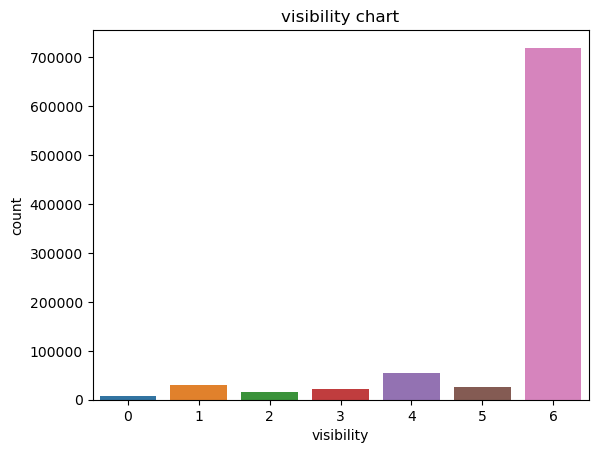

In [38]:
# statistics the visibility
visibility = weather_data1.select("visibility").groupBy("visibility").count()
data = visibility.toPandas()
sns.barplot(x = data["visibility"], y=data["count"])
plt.xlabel("visibility")
plt.ylabel("count")
plt.title("visibility chart")
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


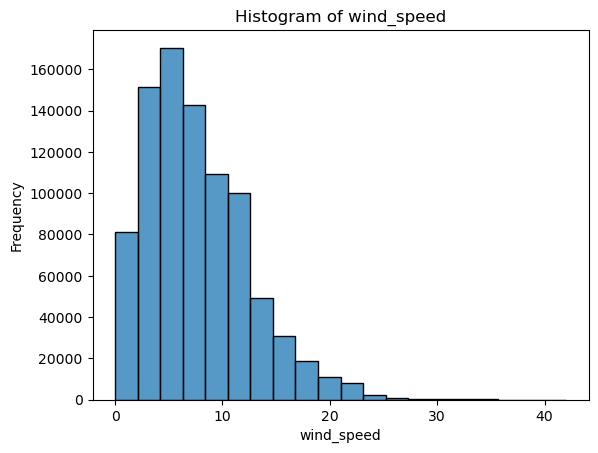

In [79]:
# statistics of the wind_speed
historam(weather_data1,"wind_speed")

# traffic_data 

In [92]:
# copy to another dataset
traffic_data1 = traffic_data

In [93]:
# print schmea data
traffic_data1.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- accident: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- no_of_vehicles: integer (nullable = true)
 |-- route_id: string (nullable = true)
 |-- vehicles: integer (nullable = true)



In [94]:
# see top 10 data
traffic_data1.show(10)

+--------------------+--------+----------+----+--------------+-------------------+--------+
|                 _id|accident|      date|hour|no_of_vehicles|           route_id|vehicles|
+--------------------+--------+----------+----+--------------+-------------------+--------+
|{662deb934a6e679a...|       0|01-01-2017|   0|           453|Alabama_Alaska_5878|     453|
|{662deb934a6e679a...|       1|01-01-2017| 100|           453|Alabama_Alaska_5878|     946|
|{662deb934a6e679a...|       0|01-01-2017| 200|          1124|Alabama_Alaska_5878|    1124|
|{662deb934a6e679a...|       0|01-01-2017| 300|          1124|Alabama_Alaska_5878|    1124|
|{662deb934a6e679a...|       0|01-01-2017| 400|          1124|Alabama_Alaska_5878|    1124|
|{662deb934a6e679a...|       0|01-01-2017| 500|          1124|Alabama_Alaska_5878|    1124|
|{662deb934a6e679a...|       0|01-01-2017| 600|          1124|Alabama_Alaska_5878|    1124|
|{662deb934a6e679a...|       0|01-01-2017| 700|          1124|Alabama_Alaska_587

In [95]:
# see the describe the data with only integer format
traffic_data1.select(['accident','hour','no_of_vehicles','vehicles']).describe().show()

+-------+--------------------+-----------------+------------------+------------------+
|summary|            accident|             hour|    no_of_vehicles|          vehicles|
+-------+--------------------+-----------------+------------------+------------------+
|  count|             1521000|          1521000|           1521000|           1521000|
|   mean|0.052671926364234053|           1150.0|1006.4926055226824|1032.4598652202499|
| stddev| 0.22337776823828873|692.2188827970837|289.29658098473203|306.17764671771033|
|    min|                   0|                0|               118|               118|
|    max|                   1|             2300|              1124|              1617|
+-------+--------------------+-----------------+------------------+------------------+



In [96]:
#driver_null_missing = driver_df.isnull().sum()/driver_df.isnull().count().sort_values(descending = True).todataframes()
traffic_data_missing = traffic_data1.agg(*[
    ((1-sum(col(c).isNotNull().cast("int")) / count('*'))*100).alias(c + '_miss(%)')
    for c in traffic_data1.columns
])
traffic_data_missing.show()

+-----------+----------------+------------+------------+----------------------+----------------+----------------+
|_id_miss(%)|accident_miss(%)|date_miss(%)|hour_miss(%)|no_of_vehicles_miss(%)|route_id_miss(%)|vehicles_miss(%)|
+-----------+----------------+------------+------------+----------------------+----------------+----------------+
|        0.0|             0.0|         0.0|         0.0|                   0.0|             0.0|             0.0|
+-----------+----------------+------------+------------+----------------------+----------------+----------------+



In [120]:
# No data missing value 
# Coppy driver_df to driver_df1
traffic_data1 = traffic_data


+-----+------+
|delay| count|
+-----+------+
|    1| 37113|
|    0|528997|
+-----+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


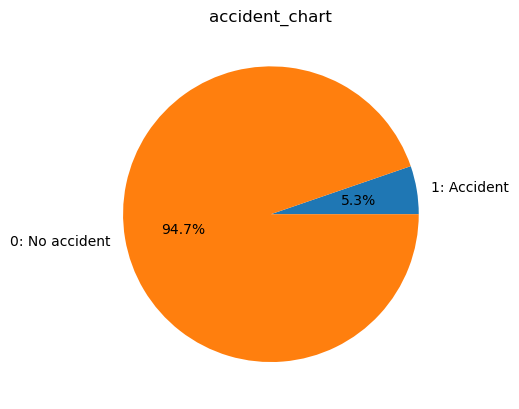

In [99]:
# statistic the ratio traffic
accident = traffic_data1.select("accident").groupBy("accident").count()
delay.show()

accident_chart = accident.toPandas()
plt.pie(accident_chart['count'], labels = ['1: Accident','0: No accident'], autopct='%1.1f%%')
plt.title("accident_chart")
plt.show()

# Determinate the correlation of varibles with Delay varible

In [81]:
#Find delays based on precipitation  buckets

# Filter truck_schedule_data for delayed routes 
filtered_routes = truck_schedule_data.filter((col("delay") == 1)) # & (col("origin") == "Alabama")

# Join filtered_routes with city_details to get city_id
joined_routes = filtered_routes.join(city_details, filtered_routes["origin"] == city_details["name"], "left")

# Join joined_routes with weather_data to get weather information
joined_data = joined_routes.join(weather_data, joined_routes["city_id"] == weather_data["city_id"], "left")

+---------------+------+------+
|delay_fuel_type|diesel|   gas|
+---------------+------+------+
|              0|306266|222342|
|              1| 21494| 15597|
+---------------+------+------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


<Axes: >

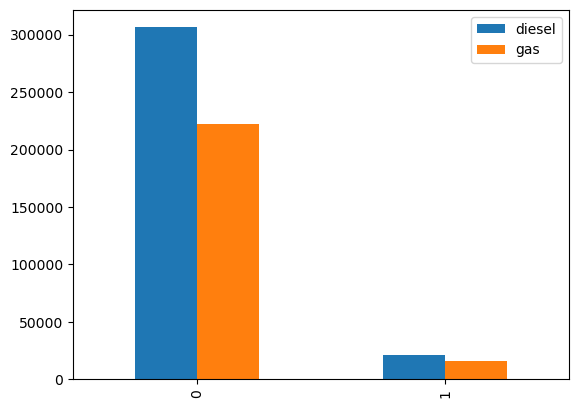

In [83]:
# compare fuel_type and delay
df = detail_truck_scheduel.crosstab("delay", "fuel_type")
df.show()

detail_truck_scheduel.crosstab("delay", "fuel_type").toPandas().plot.bar()

#### There is no significant difference in trip delays between diesel and gas trucks. However, the overall assessment is that the number of trucks using diesel is 1.5 times more than the number of trucks using gas.

+-----+------------------+
|delay|    avg(truck_age)|
+-----+------------------+
|    0|14.488244597130578|
|    1|14.529454584670136|
+-----+------------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

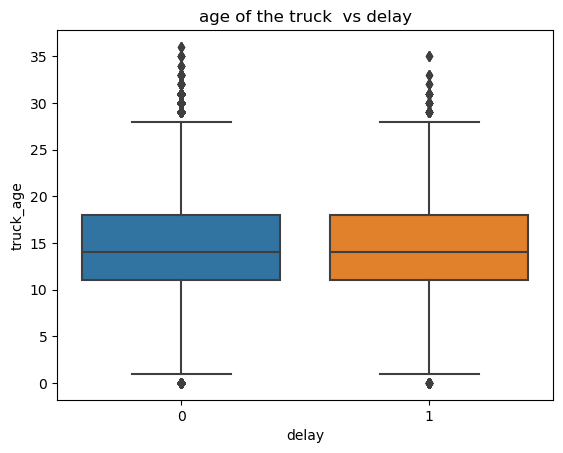

In [84]:
# Compare truck_age and delay
detail_truck_scheduel.groupBy("delay").agg({"truck_age": "mean"}).show()

# Trực quan hóa phân phối của dữ liệu theo biến phân loại 'fuel_type'
sns.boxplot(x="delay", y="truck_age", data=detail_truck_scheduel.toPandas())
plt.title("age of the truck  vs delay")
plt.show()


#### We can also see that the delay does not come from the number of years of use of the truck, but according to the chart, sometimes the longer the truck is used, the higher the punctuality.

+-----+------------------+
|delay|     avg(distance)|
+-----+------------------+
|    1|1925.8859763425169|
|    0|1228.1726354969776|
+-----+------------------+



C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

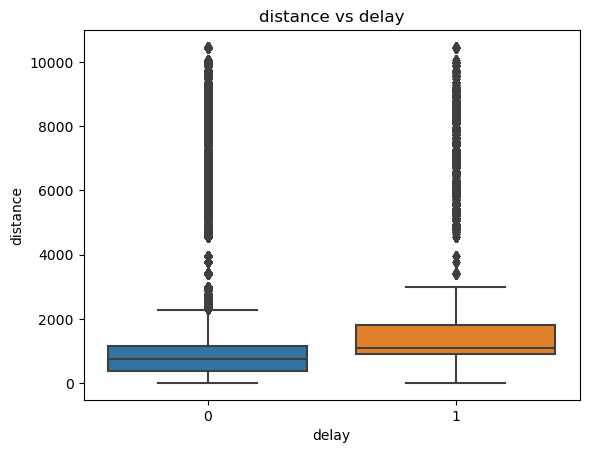

In [87]:
# join data
routes_truck_scheduel = truck_schedule_data1.join(routes_df1, truck_schedule_data1["route_id"] 
                                                            == routes_df1["route_id"], "inner")

routes_truck_scheduel.groupBy("delay").agg({"distance": "mean"}).show()

# Trực quan hóa phân phối của dữ liệu theo biến phân loại 'fuel_type'
sns.boxplot(x="delay", y="distance", data=routes_truck_scheduel.toPandas())
plt.title("distance vs delay")
plt.show()

#### The average distance of delayed buses is high compared to buses that arrive on time. It is possible that the route also partly affects whether or not you are late

## Analyze whether there are frequent delays on specific routes.

In [136]:
# Find the months with most delays

# Filter for delayed routes
delayed_routes = truck_schedule_data.filter(col("delay") == 1)

# Extract year and month from the 'date' column
delayed_routes = delayed_routes.withColumn("year", year(col("date")))
delayed_routes = delayed_routes.withColumn("month", month(col("date")))

# Group by year and month to count delays and unique routes affected
monthly_delays = delayed_routes.groupBy("year", "month").agg(
    sum("delay").alias("total_delays"),
    countDistinct("route_id").alias("unique_routes_affected")
)

# Create a window specification to rank months by total delays
window_spec = Window.partitionBy("year").orderBy(col("total_delays").desc())

# Add a rank column to find the month with the most delays for each year
ranked_months = monthly_delays.withColumn("rank", dense_rank().over(window_spec))

# Filter for the top-ranked months (most delays)
most_delayed_months = ranked_months.filter(col("rank") == 1)

# filter the delay by year
delayed_year = delayed_routes.groupBy("year").agg(sum("delay").alias("totlal_delay")).orderBy(col("year"))


In [137]:
# Show the result
delayed_year.show()

+----+------------+
|year|totlal_delay|
+----+------------+
|2017|       19273|
|2018|       17840|
+----+------------+



In [138]:
# Show the result
most_delayed_months.show()

+----+-----+------------+----------------------+----+
|year|month|total_delays|unique_routes_affected|rank|
+----+-----+------------+----------------------+----+
|2017|    1|        3740|                  1404|   1|
|2018|    1|        1826|                  1009|   1|
+----+-----+------------+----------------------+----+



In [139]:
# Show the result
ranked_months.show()

+----+-----+------------+----------------------+----+
|year|month|total_delays|unique_routes_affected|rank|
+----+-----+------------+----------------------+----+
|2017|    1|        3740|                  1404|   1|
|2017|    3|        2495|                  1208|   2|
|2017|   12|        2339|                  1172|   3|
|2017|    5|        1571|                  1103|   4|
|2017|    2|        1360|                   865|   5|
|2017|    8|        1300|                   986|   6|
|2017|   10|        1237|                   889|   7|
|2017|    9|        1237|                   891|   7|
|2017|    4|        1158|                   818|   8|
|2017|   11|        1140|                   873|   9|
|2017|    6|         928|                   790|  10|
|2017|    7|         768|                   608|  11|
|2018|    1|        1826|                  1009|   1|
|2018|    3|        1818|                  1042|   2|
|2018|    2|        1797|                  1025|   3|
|2018|   11|        1735|   

In [101]:
# Find the most congested routes

# Filter for delayed routes
delayed_routes = truck_schedule_data1.filter(col("delay") == 1)

# Group by origin and destination to count delays
route_counts = delayed_routes.groupBy("origin", "destination").agg(count("*").alias("total_delays"))

# Create a window specification to rank routes by total delays
window_spec = Window.orderBy(col("total_delays").desc())

# Use the rank() function as a window function
ranked_routes = route_counts.withColumn("rank", count("*").over(window_spec))

# Filter for the top 10 most congested routes
most_congested_routes = ranked_routes.filter(col("rank") <= 20).select("origin", "destination", "total_delays")

# Show the result
most_congested_routes.show()

+--------------------+--------------------+------------+
|              origin|         destination|total_delays|
+--------------------+--------------------+------------+
|   South Dakota Park|Pennsylvania Furnace|         104|
|Pennsylvania Furnace|   South Dakota Park|         104|
|       Nebraska City|Pennsylvania Furnace|          99|
|Pennsylvania Furnace|       Nebraska City|          99|
|              Nevada|           Worcester|          95|
|           Worcester|              Nevada|          95|
|       Oklahoma City|Pennsylvania Furnace|          94|
|Pennsylvania Furnace|       Oklahoma City|          94|
|Pennsylvania Furnace|       Arkansas City|          92|
|       Arkansas City|Pennsylvania Furnace|          92|
|      Minnesota City|           Worcester|          91|
|             Alabama|   Mississippi State|          91|
|Pennsylvania Furnace|         Kansas City|          91|
|           Worcester|      Minnesota City|          91|
|         Kansas City|Pennsylva

In [102]:
#Find delays based on precipitation  buckets

# Filter truck_schedule_data for delayed routes 
filtered_routes = truck_schedule_data.filter((col("delay") == 1)) # & (col("origin") == "Alabama")

# Join filtered_routes with city_details to get city_id
joined_routes = filtered_routes.join(city_details, filtered_routes["origin"] == city_details["name"], "left")

# Join joined_routes with weather_data to get weather information
joined_data = joined_routes.join(weather_data, joined_routes["city_id"] == weather_data["city_id"], "left")


# Define precipitation buckets
precip_buckets = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

# Create a new column to bucket precipitation
joined_data = joined_data.withColumn(
    "precip_bucket",
    when(col("precip").isNull(), "Other").otherwise(
        when(col("precip").isin(precip_buckets), col("precip")).otherwise("Other")
    )
)


# Group by precipitation buckets and aggregate total routes
route_counts = joined_data.groupBy("precip_bucket").agg(
    {"route_id": "count"}
).withColumnRenamed("count(route_id)", "routeCount")



# Group by precipitation buckets and aggregate delayed routes
delayed_route_counts = joined_data.filter(col("delay") == 1).groupBy("precip_bucket").agg(
    {"delay": "sum"}
).withColumnRenamed("sum(delay)", "totalDelays")

# Join the two DataFrames on 'precip_bucket' column
agg_result = route_counts.join(delayed_route_counts, "precip_bucket", "left")

# Filter the DataFrame to keep only rows with precip_bucket 1.0 or 0.5
filtered_df = agg_result.filter((col("precip_bucket") == 1.0) | (col("precip_bucket") == 0.5))

# Show the filtered DataFrame
filtered_df.show()

+-------------+----------+-----------+
|precip_bucket|routeCount|totalDelays|
+-------------+----------+-----------+
|          1.0|      3377|       3377|
|          0.5|    106474|     106474|
+-------------+----------+-----------+



In [103]:
# Calculate average delay under different weather conditions

# Convert date and time columns to timestamp
truck_schedule_data1 = truck_schedule_data1.withColumn(
    "departure_timestamp", unix_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss.SSSSSSSSS").cast("timestamp")
)

truck_schedule_data1 = truck_schedule_data1.withColumn(
    "arrival_timestamp", unix_timestamp(col("planned_eta"), "yyyy-MM-dd HH:mm:ss.SSSSSSSSS").cast("timestamp")
)

truck_schedule_data1 = truck_schedule_data1.withColumn(
    "duration_minutes", abs((col("arrival_timestamp").cast("long") - col("departure_timestamp").cast("long")) / 60)
)

# Extract the date from the timestamp
truck_schedule_data1 = truck_schedule_data1.withColumn("date", expr("date(departure_timestamp)"))

# Extract the hour from the timestamp
truck_schedule_data1 = truck_schedule_data1.withColumn("dep_hour", expr("hour(departure_timestamp)"))

# Convert the "date" column in truck_schedule_data to a string format that matches the "date" column in weather_data
truck_schedule_data1 = truck_schedule_data1.withColumn("date_str", expr("date_format(departure_timestamp, 'yyyy-MM-dd')"))

In [104]:
# Join truck_schedule_data with weather_data based on date and hour
joined_data_schedule = truck_schedule_data1.join(
    weather_data1,
    (truck_schedule_data1["date_str"] == weather_data1["date"]) & (col("dep_hour") == (weather_data1["hour"]/100)),
    "inner"
)

# Calculate average delay under different weather conditions
avg_delay_by_weather = joined_data_schedule.groupBy("description").agg(avg("duration_minutes").alias("avg_duration_minutes"))


avg_delay_by_weather.show()

+--------------------+--------------------+
|         description|avg_duration_minutes|
+--------------------+--------------------+
|Patchy sleet poss...|  2017.9876896794285|
|              Cloudy|   1453.089698394298|
|          Light rain|  1494.3845682553379|
|Moderate or heavy...|  1254.2630036246983|
|          Heavy rain|  1669.1479993722824|
|        Blowing snow|  1532.3954133228958|
|Patchy rain possible|  1547.3405869811031|
|Torrential rain s...|  1502.6718910356715|
|Patchy snow possible|  1330.7246535456256|
|Moderate or heavy...|  1491.6352300111832|
|   Patchy light rain|  1425.3093642280066|
|                 Fog|  1505.5555861546616|
|       Partly cloudy|  1537.9875722032414|
|   Patchy heavy snow|   1369.734401676897|
|               Sunny|  1533.5734759557602|
|Patchy light drizzle|   1476.931371915841|
|Moderate or heavy...|   2368.289678260855|
|       Light drizzle|  1451.3323913369604|
| Heavy rain at times|  1724.3328998640675|
|Patchy light rain...|  1559.781

In [105]:
filtered_truck = truck_schedule_data1.filter((col("delay") == 1))
# Join truck_schedule_data with weather_data based on date and hour
joined_data_schedule = filtered_truck.join(
    weather_data1,
    (filtered_truck["date_str"] == weather_data1["date"]) & (col("dep_hour") == (weather_data1["hour"]/100)),
    "left"
)

# Calculate average delay under different weather conditions
delay_by_weather = joined_data_schedule.groupBy("description").agg(count("delay").alias("Total_delay"))\
.orderBy(col("Total_delay").desc())
# Define the filter condition using regex

Total_delay_weather = delay_by_weather.filter(col("description").rlike(".*snow.*") | col("description").rlike(".*rain.*"))
Total_delay_weather.show()

+--------------------+-----------+
|         description|Total_delay|
+--------------------+-----------+
|Patchy rain possible|      53787|
|   Light rain shower|      50591|
|Moderate or heavy...|      37439|
|          Light rain|      27715|
|          Heavy snow|      26935|
|       Moderate rain|      23823|
|       Moderate snow|      17942|
|          Light snow|      14674|
|          Heavy rain|      14035|
|Patchy moderate snow|       8916|
|Torrential rain s...|       8528|
|   Patchy light snow|       8240|
|Moderate rain at ...|       7683|
|   Patchy heavy snow|       7401|
|   Patchy light rain|       5947|
|Patchy light rain...|       3317|
|Patchy snow possible|       3262|
|Moderate or heavy...|       2453|
|Moderate or heavy...|       2275|
| Heavy rain at times|       1736|
+--------------------+-----------+
only showing top 20 rows



In [106]:
# Show the top routes with the highest accident rates


# Group by route_id and calculate the average number of accidents per route
route_accident_stats = traffic_data1.groupBy("route_id").agg(avg("accident").alias("avg_accidents_per_route"))

# Sort routes by average accidents in descending order
top_accident_routes = route_accident_stats.orderBy(col("avg_accidents_per_route").desc())


top_accident_routes.show()

+--------------------+-----------------------+
|            route_id|avg_accidents_per_route|
+--------------------+-----------------------+
|Alabama_New_Mexic...|   0.057534246575342465|
|Alabama_Minnesota...|   0.056678082191780825|
|Alabama_Washingto...|    0.05662100456621005|
|Alabama_Louisiana...|    0.05650684931506849|
|Alabama_Dakota_56716|    0.05644977168949772|
|Alabama_Montana_4...|    0.05627853881278539|
|Alabama_Californi...|    0.05593607305936073|
| Alabama_Alaska_5878|    0.05593607305936073|
|Alabama_Hawaiian_...|    0.05593607305936073|
|Alabama_Virginia_...|     0.0557648401826484|
|Alabama_Carolina_...|    0.05565068493150685|
|Alabama_New_Hamps...|   0.055365296803652965|
|Alabama_Utah_Pur_...|    0.05485159817351598|
|Alabama_Maryland_...|     0.0547945205479452|
|Alabama_Indianapo...|    0.05468036529680365|
|Alabama_Floridabl...|    0.05468036529680365|
|Alabama_West_Virg...|   0.054509132420091325|
|Alabama_Maine-Sor...|   0.054452054794520546|
|Alabama_Dela

In [121]:
# create the date_str column and chance the format value
traffic_data1 = traffic_data1.withColumn("date_str", date_format(to_date(col("date"), "dd-MM-yyyy"), "yyyy-MM-dd"))

# filter the data by delay and accident
acident_data = traffic_data1.filter(col("accident") == 1)
delay_data = truck_schedule_data1.filter(col("delay") == 1)

# Join truck_schedule_data with weather_data based on date and hour
joined_data_traffic = delay_data.join(
    acident_data,
    (delay_data["route_id"] == acident_data["route_id"]) & (delay_data["date_str"] == acident_data["date_str"]),"left")

# 
filter_data_traffic = joined_data_traffic.filter(col("accident").isNull() == False)

# Calculate average delay under different weather conditions
delay_by_traffic = filter_data_traffic.groupBy("origin","destination").agg(count("*").alias("Total_delay")).\
orderBy(col("Total_delay").desc())

delay_by_traffic.show()

+-------+--------------------+-----------+
| origin|         destination|Total_delay|
+-------+--------------------+-----------+
|Alabama|   Mississippi State|        133|
|Alabama|       Nebraska City|        121|
|Alabama|   South Dakota Park|        117|
|Alabama|       Arkansas City|        109|
|Alabama|         Kansas City|        102|
|Alabama|       Oklahoma City|         99|
|Alabama|              Alaska|         59|
|Alabama|         Idaho Falls|         59|
|Alabama|          Texas City|         58|
| Alaska|Pennsylvania Furnace|         51|
|Alabama|    Hawaiian Gardens|         50|
|Alabama|             Arizona|         48|
|Alabama|     California City|         45|
|Alabama|    Colorado Springs|         42|
|Alabama|         Oregon City|         42|
|Alabama|       Missouri City|         41|
|Alabama|       Floridablanca|         33|
| Alaska|             Alabama|         33|
| Alaska|            Delaware|         28|
|Alabama|             Montana|         25|
+-------+--

In [122]:
#Perform cluster analysis on city details

# Assemble latitude and longitude into a feature vector
feature_cols = ['lat', 'lon']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
city_data = assembler.transform(city_details)


# Choose the number of clusters (K)
k = 5

# Fit K-means clustering model
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(city_data)

# Get cluster assignments for each city
clustered_data = model.transform(city_data)

# Perform cluster analysis on 'cluster' column
clustered_data.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         3|    5|
|         4|    3|
|         2|    6|
|         0|   34|
+----------+-----+



In [140]:
clustered_data.show(10)

+--------------------+-------+------+--------+----------------+-----------------+----------+
|                 _id|city_id|   lat|     lon|            name|         features|prediction|
+--------------------+-------+------+--------+----------------+-----------------+----------+
|{65df3f2773bdaf54...|      1|42.998| -78.185|         Alabama| [42.998,-78.185]|         0|
|{65df3f2773bdaf54...|      2|16.559| -93.973|          Alaska| [16.559,-93.973]|         4|
|{65df3f2773bdaf54...|      3|15.633| -87.317|         Arizona| [15.633,-87.317]|         4|
|{65df3f2773bdaf54...|      4|37.062| -97.038|   Arkansas City| [37.062,-97.038]|         0|
|{65df3f2773bdaf54...|      5|35.126|-117.985| California City|[35.126,-117.985]|         3|
|{65df3f2773bdaf54...|      6|38.834|-104.821|Colorado Springs|[38.834,-104.821]|         3|
|{65df3f2773bdaf54...|      7|41.053| -73.539|        Stamford| [41.053,-73.539]|         0|
|{65df3f2773bdaf54...|      8|40.299| -83.068|        Delaware| [40.29

In [124]:
#find nearest delivery center to given Coordinates

pandas_df = city_details.toPandas()

# Create a new column 'geom' with WKT representations
pandas_df['geom'] = pandas_df.apply(lambda row: Point(row['lon'], row['lat']).wkt, axis=1)

city_details_spark_df = spark.createDataFrame(pandas_df)

transformed_city_details = city_details_spark_df.selectExpr("name as city_name", "city_id", "st_geomFromWKT(geom) as geometry")

transformed_city_details.show(5)

# Sample delivery coordinates (latitude, longitude)
delivery_coordinates = [(40.7128, -74.0060), (34.0522, -118.2437), (51.5074, -0.1278)]

# Load the delivery coordinates into a SpatialRDD
delivery_rdd = Adapter.toSpatialRdd(transformed_city_details, "geometry")

# Create a spatial index on the delivery_rdd for efficient KNN queries
delivery_rdd.buildIndex(IndexType.RTREE, False)

# Calculate distances using Apache Sedona (GeoSpark)
nearest_centers = []

for i, coord in enumerate(delivery_coordinates):
    # Create a Point for the current delivery coordinate
    delivery_point = Point(coord[1], coord[0])
    
    
    # Perform a KNN query to find the nearest center
    knn_result = KNNQuery.SpatialKnnQuery(delivery_rdd, delivery_point, 1, True)
    c_id=int(re.findall(r'\d+', knn_result[0].userData)[0])
    
    # Get the nearest center name
    nearest_center = city_details.filter(city_details["city_id"] == c_id).select("name").first()[0]

    nearest_centers.append(nearest_center)

# Print the nearest centers for each delivery coordinate
for i, coord in enumerate(delivery_coordinates):
    print(f"Delivery Coordinate {i + 1}: {coord} -> Nearest Center: {nearest_centers[i]}")

C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\ProgramData\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+---------------+-------+--------------------+
|      city_name|city_id|            geometry|
+---------------+-------+--------------------+
|        Alabama|      1|POINT (-78.185 42...|
|         Alaska|      2|POINT (-93.973 16...|
|        Arizona|      3|POINT (-87.317 15...|
|  Arkansas City|      4|POINT (-97.038 37...|
|California City|      5|POINT (-117.985 3...|
+---------------+-------+--------------------+
only showing top 5 rows

Delivery Coordinate 1: (40.7128, -74.006) -> Nearest Center: New York
Delivery Coordinate 2: (34.0522, -118.2437) -> Nearest Center: Hawaiian Gardens
Delivery Coordinate 3: (51.5074, -0.1278) -> Nearest Center: Montana
